In [1]:
# 引入所需库
import numpy as np
import pandas as pd
import time
import copy

In [2]:
# 读取文件及数据初始化
pt_tmp=pd.read_excel("JSP_dataset.xlsx",sheet_name="Processing Time",index_col =[0])
ms_tmp=pd.read_excel("JSP_dataset.xlsx",sheet_name="Machines Sequence",index_col =[0])

dfshape=pt_tmp.shape
num_mc=dfshape[1] # 机器台数
num_job=dfshape[0] # 工序数
num_gene=num_mc*num_job # 单条染色体中的基因数

pt=[list(map(int, pt_tmp.iloc[i])) for i in range(num_job)]
ms=[list(map(int,ms_tmp.iloc[i])) for i in range(num_job)]



In [3]:
# 设定初始参数

POPULATION_SIZE = 30 # 种群大小
CROSSOVER_RATE = 0.8 # 交叉概率
MUTATION_RATE = 0.2 # 变异概率
MUTATION_SELECTION_RATE = 0.2 # 变异基因数目选择率
NUM_MUTATION_JOBS = round(num_gene*MUTATION_SELECTION_RATE) # 变异基因数
NUM_ITERATION = 1000 # 迭代次数
ckeck_time = False # 是否计算运行时间

In [4]:
# 开始计时
if ckeck_time:
    start_time = time.time()

In [5]:
# 生成初始种群
Tbest=float('inf') # 用于记录最优解,初始值为无穷大
best_list,best_obj=[],[] # 用于记录最优解的染色体和目标函数值
population_list=[] # 用于存储种群
makespan_record=[] # 用于记录每次迭代的最优解

for i in range(POPULATION_SIZE):
    nxm_random_num=list(np.random.permutation(num_gene)) # 生成一个随机序列，from 0 to num_gene-1   
    population_list.append(nxm_random_num) # 添加到种群中
    for j in range(num_gene):
        population_list[i][j]=population_list[i][j]%num_job # 生成随机基因序列

optimal sequence [2, 5, 1, 2, 8, 6, 3, 3, 2, 10, 5, 8, 10, 2, 3, 4, 7, 8, 8, 10, 5, 6, 10, 2, 7, 10, 7, 4, 6, 1, 1, 4, 3, 9, 8, 4, 5, 2, 1, 3, 7, 6, 8, 4, 4, 7, 10, 9, 1, 10, 7, 5, 6, 8, 1, 6, 10, 9, 9, 6, 4, 3, 7, 5, 1, 6, 8, 1, 5, 9, 2, 7, 3, 8, 7, 7, 2, 1, 9, 4, 8, 5, 4, 9, 5, 10, 9, 3, 10, 9, 3, 9, 2, 6, 4, 5, 6, 3, 1, 2]
optimal value:1239.000000


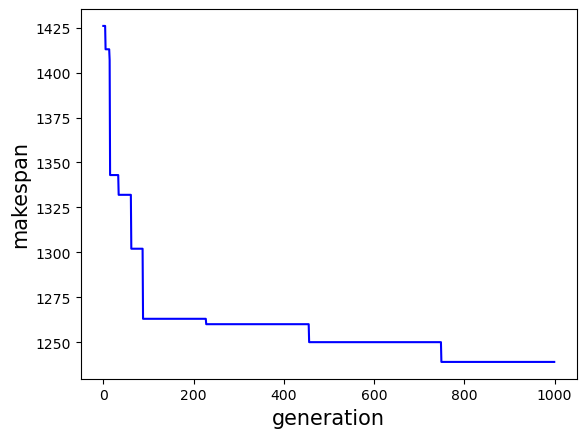

In [6]:
# 生成新一代
for n in range(NUM_ITERATION):
    Tbest_now=float('inf') # 用于记录当前最优解,初始值为无穷大      
   
    # 交配
    parent_list=copy.deepcopy(population_list)      # 深拷贝父母染色体
    offspring_list=copy.deepcopy(population_list)   # 深拷贝子代染色体
    S=list(np.random.permutation(POPULATION_SIZE))  # 返回随机的序列，用于选择交配父母染色体
    
    for m in range(int(POPULATION_SIZE/2)):         # 交配次数
        crossover_prob=np.random.rand()             # 生成随机交叉概率
        if CROSSOVER_RATE>=crossover_prob:          # 交叉
            parent_1= population_list[S[2*m]][:]    # 相邻两个进行交叉
            parent_2= population_list[S[2*m+1]][:]
            child_1=parent_1[:]
            child_2=parent_2[:]
            cutpoint=list(np.random.choice(num_gene, 2, replace=False)) # 生成两个随机的交叉点
            cutpoint.sort() # 交叉点排序
        
            child_1[cutpoint[0]:cutpoint[1]]=parent_2[cutpoint[0]:cutpoint[1]]
            child_2[cutpoint[0]:cutpoint[1]]=parent_1[cutpoint[0]:cutpoint[1]]
            offspring_list[S[2*m]]=child_1[:]
            offspring_list[S[2*m+1]]=child_2[:]
    
    # 修复，确保每个工序在每台机器上只出现一次
    for m in range(POPULATION_SIZE):
        job_count={} # 用于记录每个数字出现的次数和第一次出现的位置
        larger,less=[],[] # 'larger'记录超过正常次数的染色体，less记录小于正常次数的染色体
        for i in range(num_job):
            if i in offspring_list[m]:
                count=offspring_list[m].count(i) # 计算染色体中每个数字出现的次数
                pos=offspring_list[m].index(i) # 记录第一次出现的位置
                job_count[i]=[count,pos] # 将以上两个值存储到job_count字典中
            else:
                count=0
                job_count[i]=[count,0]
            if count>num_mc:
                larger.append(i)
            elif count<num_mc:
                less.append(i)
                
        for k in range(len(larger)):
            chg_job=larger[k] # 需要处理的数字
            while job_count[chg_job][0]>num_mc:
                for d in range(len(less)):
                    if job_count[less[d]][0]<num_mc:                    
                        offspring_list[m][job_count[chg_job][1]]=less[d] # 将超过正常次数的数字替换为小于正常次数的数字
                        job_count[chg_job][1]=offspring_list[m].index(chg_job) # 更新第一次出现的位置
                        job_count[chg_job][0]=job_count[chg_job][0]-1 # 更新出现次数
                        job_count[less[d]][0]=job_count[less[d]][0]+1 # 更新出现次数                   
                    if job_count[chg_job][0]==num_mc: # 如果处理完毕，则跳出循环
                        break     

    # 变异
    """循环变异，选择一个变异位点，将该位点的值赋给下一个变异位点，循环往复，直至最后一个变异位点的值赋给第一个变异位点"""""
    for m in range(len(offspring_list)):
        mutation_prob=np.random.rand() # 生成随机变异概率
        if MUTATION_RATE >= mutation_prob:
            m_chg=list(np.random.choice(num_gene, NUM_MUTATION_JOBS, replace=False)) # 选择变异的位点
            t_value_last=offspring_list[m][m_chg[0]] # 记录第一个变异位点的值
            for i in range(NUM_MUTATION_JOBS-1):
                offspring_list[m][m_chg[i]]=offspring_list[m][m_chg[i+1]] # 展示变异
            
            offspring_list[m][m_chg[NUM_MUTATION_JOBS-1]]=t_value_last # 将第一个变异位点的值赋给最后一个变异位点

    # 计算适应度
    """计算新种群的适应度
    由于需要利用轮盘法，所以需要计算每个染色体的适应度（倒数，用于轮盘）
    直接适用度用于比较，适应度越小，越优秀
    """
    total_chromosome=copy.deepcopy(parent_list)+copy.deepcopy(offspring_list) # 将亲代和子代染色体合并
    chrom_fitness,chrom_fit=[],[] # 用于存储每个染色体的倒数适应度（用于轮盘）和适应度
    total_fitness=0 # 总适应度
    for m in range(POPULATION_SIZE*2):      # 计算每个染色体的适应度
        j_keys=[j for j in range(num_job)] 
        key_count={key:0 for key in j_keys} # 初始化字典，存储每个任务已经处理的次数
        j_count={key:0 for key in j_keys}   # 初始化字典，存储每个任务的累积处理时间
        m_keys=[j+1 for j in range(num_mc)]
        m_count={key:0 for key in m_keys}   # 初始化字典，存储每台机器的累积处理时间
        
        for i in total_chromosome[m]:       # 计算每个任务的累积处理时间
            gen_t=int(pt[i][key_count[i]])  # 获取当前任务的处理时间
            gen_m=int(ms[i][key_count[i]])  # 获取当前任务的处理机器
            j_count[i]=j_count[i]+gen_t     # 累积工序i的处理时间
            m_count[gen_m]=m_count[gen_m]+gen_t # 累积gen_m机器处理时间
            
            if m_count[gen_m]<j_count[i]:   # 如果机器累计处理时间小于工序处理时间，则将机器处理时间更新为工序处理时间
                m_count[gen_m]=j_count[i]
            elif m_count[gen_m]>j_count[i]: # 如果机器累计处理时间大于工序处理时间，则将工序处理时间更新为机器处理时间
                j_count[i]=m_count[gen_m]
                # 这样做是为了确保任务按顺序在机器上执行，即等待前一个任务完成后再开始执行下一个任务。
            
            key_count[i]=key_count[i]+1     # 更新任务处理次数
    
        makespan=max(j_count.values())      # 计算最大的累积处理时间，即最大的完成时间
        chrom_fitness.append(1/makespan)    # 计算每个染色体的适应度的倒数
        chrom_fit.append(makespan)          
        total_fitness=total_fitness+chrom_fitness[m] # 计算总适应度

    # 选择
    """轮盘法选择
    根据每个染色体的适应度，计算每个染色体的概率
    然后根据概率，随机选择染色体
    """
    pk,qk=[],[] # 用于存储每个染色体的概率和累积概率
    
    for i in range(POPULATION_SIZE*2):
        pk.append(chrom_fitness[i]/total_fitness)
    for i in range(POPULATION_SIZE*2):
        cumulative=0
        for j in range(0,i+1):
            cumulative=cumulative+pk[j]
        qk.append(cumulative)
    
    selection_rand=[np.random.rand() for i in range(POPULATION_SIZE)] # 生成随机数，用于选择
    
    for i in range(POPULATION_SIZE):    # 根据随机数，选择染色体
        if selection_rand[i]<=qk[0]:    # 如果随机数小于第一个累积概率，则选择第一个染色体
            population_list[i]=copy.deepcopy(total_chromosome[0])
        else:
            for j in range(0,POPULATION_SIZE*2-1):  # 如果随机数大于第一个累积概率，则选择第一个大于随机数的累积概率对应的染色体
                if selection_rand[i]>qk[j] and selection_rand[i]<=qk[j+1]:
                    population_list[i]=copy.deepcopy(total_chromosome[j+1])
                    break
    # 比较
    """比较当前最优解和全局最优解"""
    for i in range(POPULATION_SIZE*2):
        if chrom_fit[i]<Tbest_now:
            Tbest_now=chrom_fit[i]
            sequence_now=copy.deepcopy(total_chromosome[i])
    if Tbest_now<=Tbest:
        Tbest=Tbest_now
        sequence_best=copy.deepcopy(sequence_now)
        
    makespan_record.append(Tbest)
# 输出结果
print("optimal sequence",[x+1 for x in sequence_best])
print("optimal value:%f"%Tbest)
if  ckeck_time:
    print('the elapsed time:%s'% (time.time() - start_time))

import matplotlib.pyplot as plt
%matplotlib inline
plt.plot([i for i in range(len(makespan_record))],makespan_record,'b')
plt.ylabel('makespan',fontsize=15)
plt.xlabel('generation',fontsize=15)
plt.show()

In [7]:
print("optimal sequence",[x+1 for x in sequence_best])

optimal sequence [2, 5, 1, 2, 8, 6, 3, 3, 2, 10, 5, 8, 10, 2, 3, 4, 7, 8, 8, 10, 5, 6, 10, 2, 7, 10, 7, 4, 6, 1, 1, 4, 3, 9, 8, 4, 5, 2, 1, 3, 7, 6, 8, 4, 4, 7, 10, 9, 1, 10, 7, 5, 6, 8, 1, 6, 10, 9, 9, 6, 4, 3, 7, 5, 1, 6, 8, 1, 5, 9, 2, 7, 3, 8, 7, 7, 2, 1, 9, 4, 8, 5, 4, 9, 5, 10, 9, 3, 10, 9, 3, 9, 2, 6, 4, 5, 6, 3, 1, 2]


In [14]:
import ssl
import urllib3

# 禁用 SSL 证书验证
ssl._create_default_https_context = ssl._create_unverified_context
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)


In [24]:
# 绘制甘特图

import chart_studio.plotly as py
import chart_studio.tools as tls
import plotly.figure_factory as ff
import datetime
import os
from dotenv import load_dotenv

load_dotenv()

plotly_username = os.getenv("PLOTLY_USERNAME")
plotly_api_key = os.getenv("PLOTLY_API_KEY")

tls.set_credentials_file(username=plotly_username, api_key=plotly_api_key)

m_keys=[j+1 for j in range(num_mc)]
j_keys=[j for j in range(num_job)]
key_count={key:0 for key in j_keys}
j_count={key:0 for key in j_keys}
m_count={key:0 for key in m_keys}
j_record={}
for i in sequence_best:
    gen_t=int(pt[i][key_count[i]])
    gen_m=int(ms[i][key_count[i]])
    j_count[i]=j_count[i]+gen_t
    m_count[gen_m]=m_count[gen_m]+gen_t
    
    if m_count[gen_m]<j_count[i]:
        m_count[gen_m]=j_count[i]
    elif m_count[gen_m]>j_count[i]:
        j_count[i]=m_count[gen_m]
    
    start_time=str(datetime.timedelta(seconds=j_count[i]-pt[i][key_count[i]])) # convert seconds to hours, minutes and seconds
    end_time=str(datetime.timedelta(seconds=j_count[i]))
        
    j_record[(i,gen_m)]=[start_time,end_time]
    
    key_count[i]=key_count[i]+1
        

df=[]
for m in m_keys:
    for j in j_keys:
        df.append(dict(Task='Machine %s'%(m), Start='2023-03-17 %s'%(str(j_record[(j,m)][0])), Finish='2023-03-17 %s'%(str(j_record[(j,m)][1])),Resource='Job %s'%(j+1)))
    
fig = ff.create_gantt(df, index_col='Resource', show_colorbar=True, group_tasks=True, showgrid_x=True, title='Job shop Schedule')
py.iplot(fig, filename='GA_job_shop_scheduling', world_readable=True)

PlotlyRequestError: No message

In [22]:
# 本地绘制甘特图

import plotly as py
import chart_studio.tools as tls
import plotly.figure_factory as ff
import datetime
import os
from dotenv import load_dotenv

load_dotenv()

plotly_username = os.getenv("PLOTLY_USERNAME")
plotly_api_key = os.getenv("PLOTLY_API_KEY")

tls.set_credentials_file(username=plotly_username, api_key=plotly_api_key)

m_keys=[j+1 for j in range(num_mc)]
j_keys=[j for j in range(num_job)]
key_count={key:0 for key in j_keys}
j_count={key:0 for key in j_keys}
m_count={key:0 for key in m_keys}
j_record={}
for i in sequence_best:
    gen_t=int(pt[i][key_count[i]])
    gen_m=int(ms[i][key_count[i]])
    j_count[i]=j_count[i]+gen_t
    m_count[gen_m]=m_count[gen_m]+gen_t
    
    if m_count[gen_m]<j_count[i]:
        m_count[gen_m]=j_count[i]
    elif m_count[gen_m]>j_count[i]:
        j_count[i]=m_count[gen_m]
    
    start_time=str(datetime.timedelta(seconds=j_count[i]-pt[i][key_count[i]])) # convert seconds to hours, minutes and seconds
    end_time=str(datetime.timedelta(seconds=j_count[i]))
        
    j_record[(i,gen_m)]=[start_time,end_time]
    
    key_count[i]=key_count[i]+1
        

df=[]
for m in m_keys:
    for j in j_keys:
        df.append(dict(Task='Machine %s'%(m), Start='2023-03-17 %s'%(str(j_record[(j,m)][0])), Finish='2023-03-17 %s'%(str(j_record[(j,m)][1])),Resource='Job %s'%(j+1)))
    
fig = ff.create_gantt(df, index_col='Resource', show_colorbar=True, group_tasks=True, showgrid_x=True, title='Job shop Schedule')
py.offline.iplot(fig, filename='GA_job_shop_scheduling')